# 2019 Coronavirus analysis


The goal of this analysis is to answer the question "How bad is this going to get?"


I'm applying epidiomilogical theory to try and understand where we are in the covid19 pandemic

(punchline)

In [1]:
from datetime import date

today = date.today()
print("Last ran:", today)

import warnings
warnings.filterwarnings('ignore')


Last ran: 2020-03-24


Starting off with some theory...


### The SIR epidemic model  (susceptible - infectious - recovered)

<img src="model.png">

A classic form of compartmental modeling, the idea is that a population starts off in a particular bucket (either susceptible, infectious, or recovered) and moves into the next bucket at either the transmission rate or the recovery rate.  

  
If you were to plot out the scenario mathematically, it will look like a logistic curve.


Let :
- **t** represent time   in days
- $B$ represent the transmission of the disease
- **$\gamma$** be the average recovery rate from the disease
- **N** be the total population
- ***S(t)*** be the number of people susceptible but not yet infected with the disease 
- ***I(t)*** be the number of of infectious individuals 
- ***R(t)*** are the number of individuals who recovered/removed and are now immune. Note that this includes people who've died

$\frac{dS}{dt}$ = -$\frac{\beta SI}{N}$   
$\frac{dI}{dt}$ = $\frac{\beta SI}{N}$ - $\gamma$I   
$\frac{dR}{dt}$ = $\gamma$I   

R0 = $\beta$*$\gamma$  
(COVID-2019 R0 is estimated to be between 1.4 to 3.8)

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

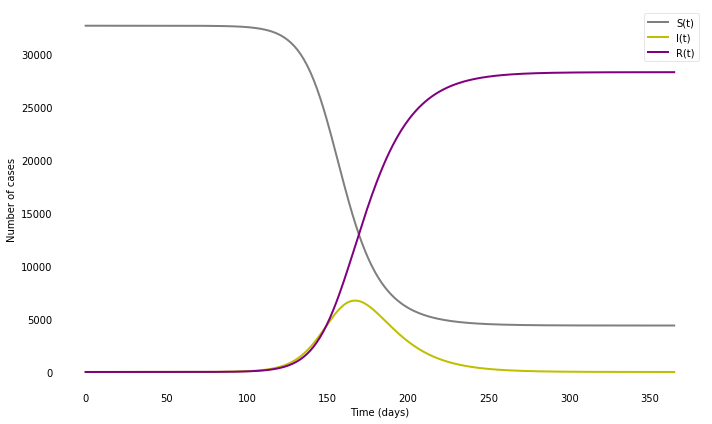

In [3]:
# total population
N = 32700000

# initial number of infected and recovered
I0 = 6
R0 = 0

# everyone else
S0 = N- I0 - R0


#rates (in 1/days)
rnot = 2.32      # estimated to be between 1.4 - 3.8
gamma = 1/14      # time to recovery or death (average of 14 days)
beta = rnot*gamma     # infection rate

# create grid of time points 
days = 365
t = np.linspace(0,days,days)

# differential equations with SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R, = y
    dSdt = -beta*S*I / N
    dIdt = (beta*S*I/N) - gamma*I
    dRdt = gamma*I
    return dSdt, dIdt, dRdt

# create initial conditions vector
y0 = S0, I0, R0

# integration SIR equation over time space
ret = odeint(deriv, y0, t, args=(N,beta,gamma))
S, I, R = ret.T


# Plot the data on three separate curves for S(t), I(t) and R(t)

fig = plt.figure(facecolor='w',figsize=(10, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'k', alpha=0.5, lw=2, label='S(t)')
ax.plot(t, I/1000, 'y', alpha=1, lw=2, label='I(t)')
ax.plot(t, R/1000, 'purple', alpha=1, lw=2, label='R(t)')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of cases')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.tight_layout()

plt.savefig('./figures/figure1.png', dpi=300)
# plt.show()

By plotting out the scenario, we can predict the moment when there is exponential increase in number of people who will be affected by the disease.

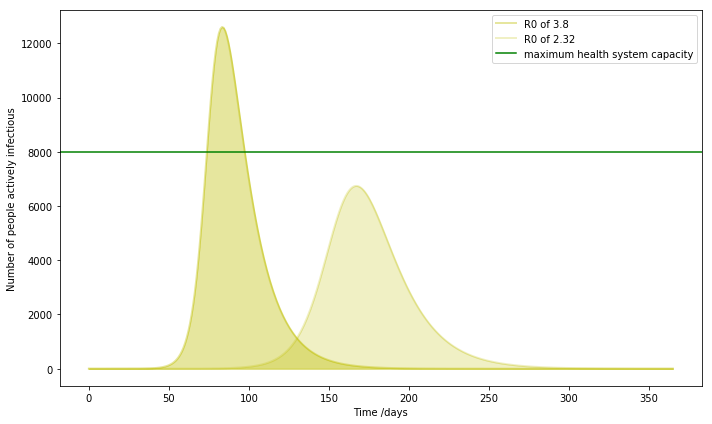

In [4]:
# comparing rnots
rnot_list = [3.8,2.32]
plt.figure(facecolor='w',figsize=(10, 6))

for rnot in rnot_list:
    #rates (in 1/days)
    gamma = 1/14      # time to recovery or death (average of 14 days)
    beta = rnot*gamma     # infection rate

    # create initial conditions vector
    y0 = S0, I0, R0

    # integration SIR equation over time space
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = ret.T


    # Plot the data on three separate curves for I(t)
    plt.plot(t, I/1000, 'y', alpha=rnot/10, lw=2, label='R0 of {}'.format(rnot))
    plt.xlabel('Time /days')
    plt.ylabel('Number of people actively infectious')
    plt.fill_between(t, I/1000, color='y', alpha = rnot/10 )

    
plt.axhline(y=8000, label='maximum health system capacity', c='g')


plt.legend()
plt.tight_layout()


plt.savefig('./figures/figure2.png', dpi=300)

plt.show()

something about flattening the curve

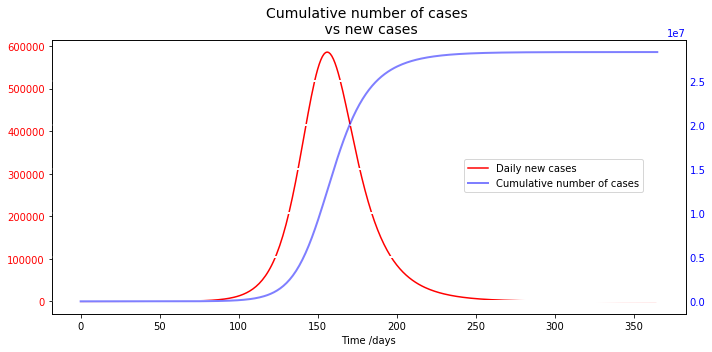

In [5]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
y = I + R
y_i = np.gradient(y)

fig = plt.figure(facecolor='w',figsize=(10, 5))
ax2 = fig.add_subplot(111, axisbelow=True)
ax2.plot(y_i, c='r', label='Daily new cases')
ax2.set_xlabel('Time /days')
ax2.tick_params(axis='y', labelcolor='r')


ax = ax2.twinx()
ax.plot(t, I+R, 'b', alpha=0.5, lw=2, label='Cumulative number of cases')
# ax.set_ylabel('Number of Cases')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.tick_params(axis='y', labelcolor='b')

ax.set_title('Cumulative number of cases \n vs new cases', fontsize=14)    

fig.legend(borderaxespad=7, loc='right')
plt.tight_layout()
plt.savefig('./figures/figure3.png', dpi=300)

# plt.show()

  
## Now, looking at the actual data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt
import numpy as np

from scipy import optimize

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

%matplotlib inline



In [7]:
df = pd.read_csv('2019-ncov.csv',index_col=0)
# df = df.iloc[:-1]
# filling missing date by taking average of the previous and preceding dates
for country in df.columns:
    df[country]['2020-01-22'] = (df[country]['2020-01-21'] + df[country]['2020-01-23'])/2

df['Total_no_china'] = df.loc[:,df.columns != 'China'].sum(axis=1)
df['Total'] = df.loc[:,df.columns != 'Total_no_china'].sum(axis=1)


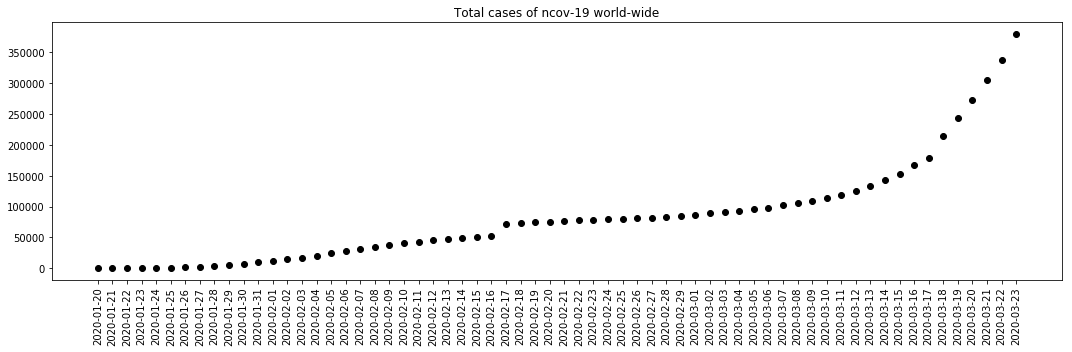

In [8]:
# figure 1
# total cases world wide

plt.figure(figsize=(15,5))

plt.scatter(x=df.index,y=df['Total'], color = 'k')
plt.xticks(rotation=90)
plt.title('Total cases of ncov-19 world-wide')
plt.tight_layout()
plt.savefig('./figures/figure4.png', dpi=300)

# plt.show()


In [9]:
# 
df.iloc[-1].sort_values(ascending=False).head(n=13)

Total             379150.0
Total_no_china    297654.0
China              81496.0
Italy              63927.0
United States      43667.0
Spain              35136.0
Germany            29056.0
Iran               23049.0
France             20123.0
South Korea         8961.0
Switzerland         8795.0
United Kingdom      6726.0
Netherlands         4764.0
Name: 2020-03-23, dtype: float64

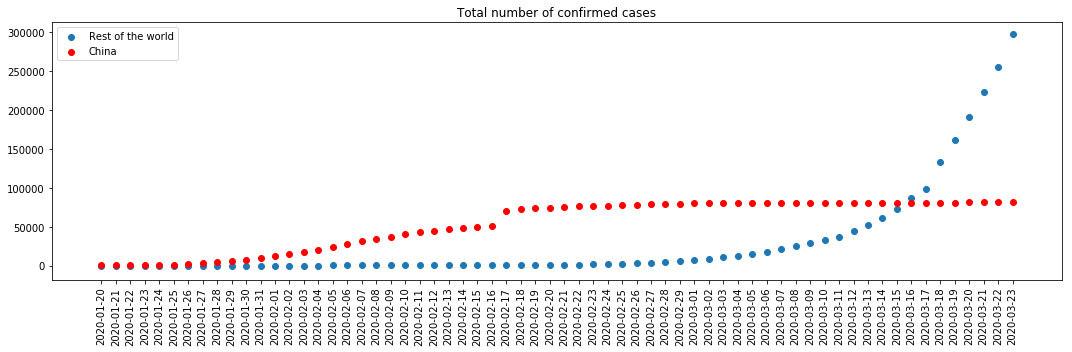

In [10]:
# fig 2
# total cases separating china and the rest of the world

plt.figure(figsize=(15,5))
plt.scatter(x=df.index,y=df['Total_no_china'], label = 'Rest of the world')
plt.scatter(x=df.index,y=df['China'], label='China', color = 'r')
plt.xticks(rotation=90)
plt.legend()
plt.title('Total number of confirmed cases')
plt.tight_layout()
plt.savefig('./figures/figure5.png', dpi=300)

plt.show()

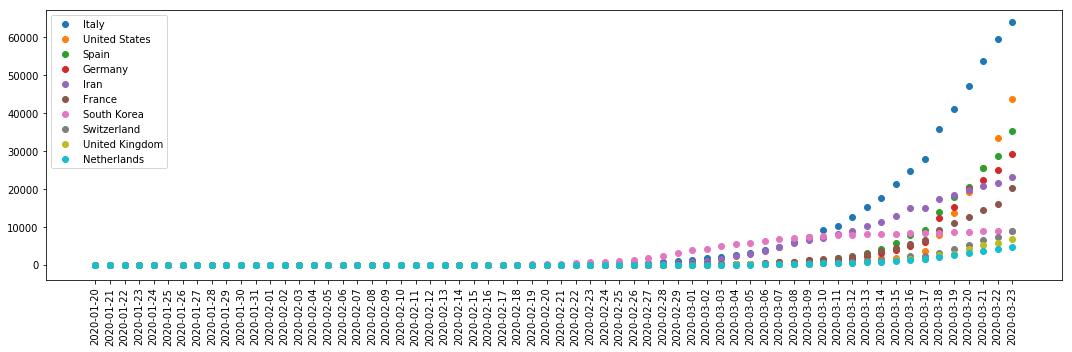

In [11]:
# fig 3
# top six countries (after china) with the highest confirmed cases


plt.figure(figsize=(15,5))

lst = ['Total', 'China', 'Total_no_china']
df2 = df[[c for c in df.columns if c not in lst]]

top10 = df2.iloc[-1].sort_values(ascending=False).head(n=10).index

for country in top10:
    plt.scatter(x=df.index, y=df2[country], label = country)

plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/figure6.png', dpi=300)

plt.show()

In [12]:
#guassian function
def fx(x, a,b,c):
    return a*np.exp(-(x-b)**2/(2*(c**2)))

# def func(x, w0, w1):
#     y = w0 + w1*x
#     return np.exp(y)/((1+np.exp(y))**2)

In [13]:
# dividing the countries by region

regions = {
    'china':['China'],
    'western pacific':['South Korea', 'Japan', 'Singapore', 'Malaysia',
                       'Australia','Philippines', 'Vietnam', 'Brunei',
                       'New Zealand', 'Cambodia', 'Mongolia', 'Fiji', 'Guam',
                      'Taiwan', 'East Timor'],
    'european':['Italy', 'France', 'Spain', 'Germany', 'Switzerland', 'Denmark',
                'Netherlands', 'United Kingdom', 'Belgium', 'Austria', 'Norway',
                'Greece', 'Czech Republic', 'Israel', 'San Marino', 'Iceland',
               'Slovenia', 'Romania', 'Poland', 'Ireland', 'Portugal', 'Finland',
                'Georgia', 'Russia', 'Serbia', 'Luxembourg', 'Croatia', 'Latvia',
                'Estonia', 'Hungary', 'Belarus', 'Albania', 'Slovakia', 'Azerbaijan',
                'Bulgaria', 'North Macedonia', 'Cyprus', 'Malta', 'Bosnia and Herzegovina',
               'Moldova', 'Lithuania', 'Andorra', 'Armenia', 'Holy See', 'Liechtenstein',
                'Monaco', 'Turkey', 'Ukraine', 'Guernsey',
                'Jersey', 'Kazakhstan', 'Uzbekistan', 'Kosovo', 'Kyrgyzstan', 'Sweden'],
    'south-east asia':['India', 'Thailand', 'Indonesia', 'Maldives', 'Bangladesh',
                       'Sri Lanka', 'Bhutan', 'Nepal'],
    'eastern mediteranean':['Iran', 'Qatar', 'Bahrain', 'Kuwait', 'United Arab Emirates',
                            'Iraq', 'Egypt', 'Lebanon', 'Saudi Arabia', 'Pakistan', 'Oman',
                            'Afghanistan', 'Tunisia', 'Morocco', 'Jordan', 'Palestine',
                           'Sudan', 'Djibouti', 'Syria'],
    'americas':['United States', 'Canada', 'Brazil', 'Chile', 'Argentina', 'Ecuador', 
                'Peru', 'Costa Rica', 'Mexico', 'Panama', 'Colombia', 'Dominican Republic',
                'Paraguay', 'Bolivia', 'Honduras', 'Jamaica', 'French Guiana', 'Martinique',
                'Antigua and Barbuda',
               'Cuba', 'Guadeloupe', 'Guyana', 'Kenya', 'Saint Vincent','El Salvador',
               'Venezuela', 'Uruguay', 'Suriname', 'Bahamas', 'Barbados',
               'Guatemala', 'Haiti', 'Saint Lucia'],
    'african':['Algeria', 'South Africa', 'Senegal', 'Burkina Faso', 'Cameroon', 'Nigeria',
               'Ivory Coast', 'Congo', 'Togo', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea',
              'Reunion', 'Sudan', 'Trinidad and Tobago', 'Namibia', 'Central African Republic',
              'Equatorial Guinea', 'Eswatini', 'Mauritania', 'Mayotte', 'Rwanda',
              'Seychelles', 'Angola', 'Benin', 'Chad','Eritrea', 'Gambia' ,'Liberia',
              'Madagascar', 'Mauritius', 'Montenegro', 'Nicaragua', 'Niger', 'Somalia',
              'Tanzania', 'Uganda', 'Zambia', 'Zimbabwe']
       
}

rsquare: 0.9384084239349373


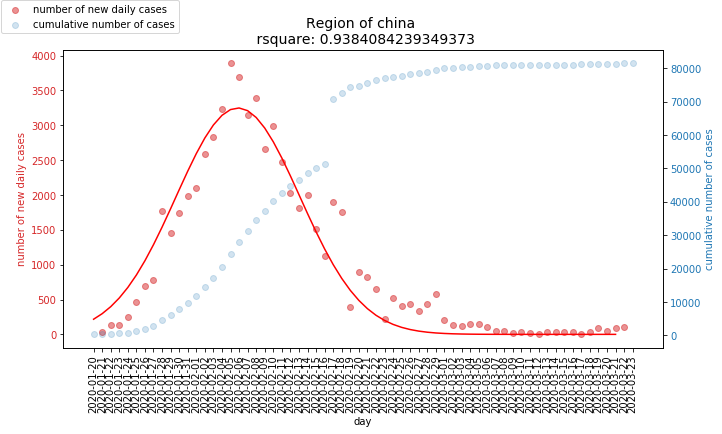

rsquare: 0.5955705113883774


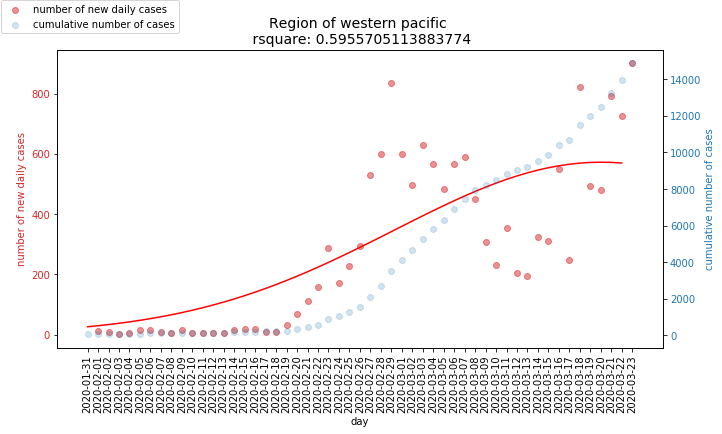

rsquare: 0.9005077280984031


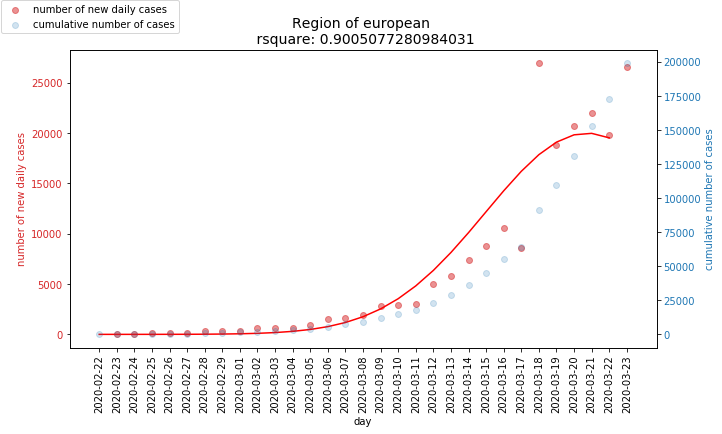

rsquare: 0.9390143027915698


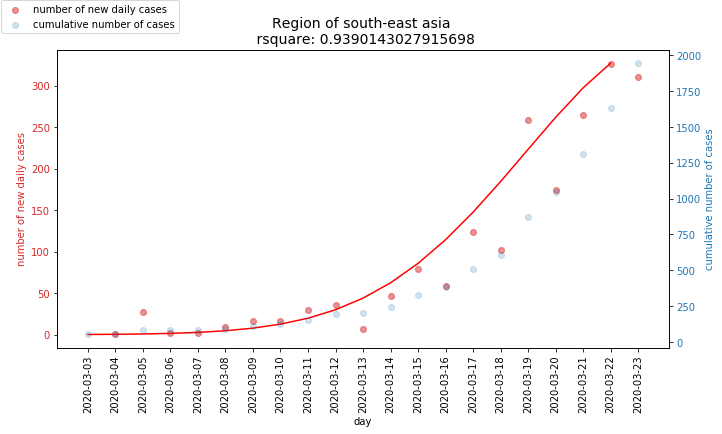

rsquare: 0.6566168901322886


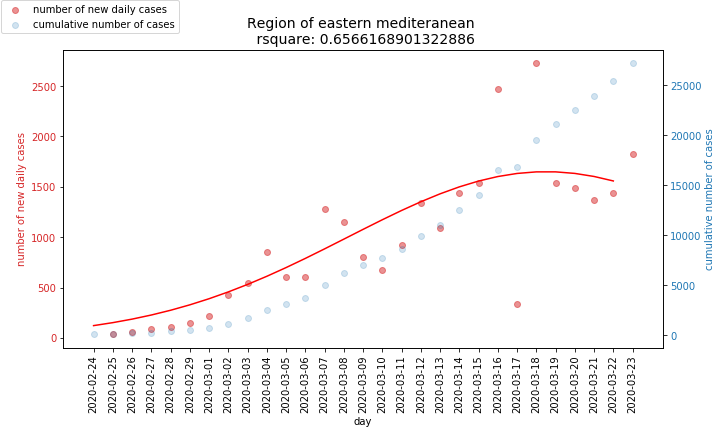

rsquare: 0.9698765628645278


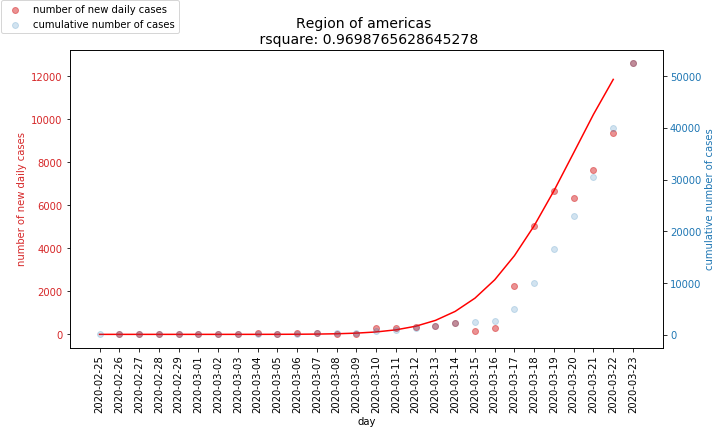

rsquare: 0.9369997388826754


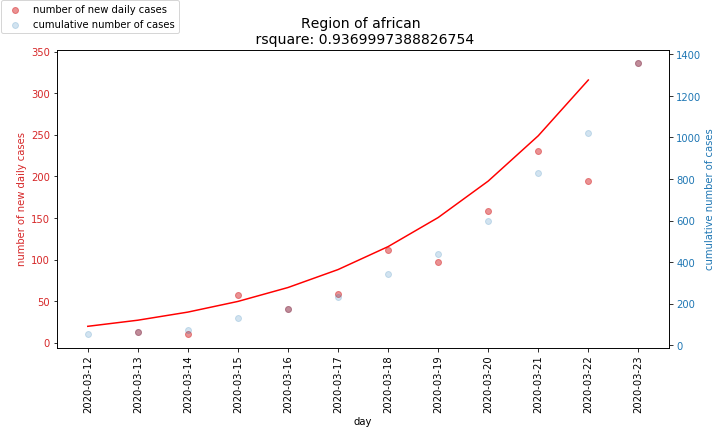

In [14]:
for region, _ in regions.items():
    df_part = df[regions[region]]
    df_part['total'] = df_part.sum(axis=1)
    df_part = df_part.loc[df_part['total']>50] #checks for at least 10 cases

    # taking derivative
    d1 = df_part['total'].diff()
    
    if region == 'china':
        d1.drop(index='2020-02-17', inplace=True)


    data1 = [d1.index, d1]
    data2 = [df_part.index, df_part['total']]

    fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

    color = 'tab:red'
    ax1.set_xlabel('day')
    ax1.set_ylabel('number of new daily cases', color=color)
    ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
    ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
    ax2.tick_params(axis='y', labelcolor=color)

    # SVR poly kernel on the second derivative
    dd1 = d1.reset_index(drop=True)
    dd1 = dd1.dropna()
    X = np.array(dd1.index)
    y = np.array(dd1)



    # regression
    bounds = ([50,15,0],[20000,90,20])
    params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
    # print(params)

    # residuals
    residuals = y - fx(X,*params)
    ssres = np.sum(residuals**2)
    sstot = np.sum((y-np.mean(y))**2)
    rsquared = 1-(ssres/sstot)
    print('rsquare: {}'.format(rsquared))

    ax1.plot(fx(X,*params), c='r')
    ax1.set_title('Region of {0} \n rsquare: {1}'.format(region, rsquared), fontsize=14)

    fig.legend(borderaxespad=0.1, loc='upper left')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.tight_layout()
    plt.savefig('./figures/fig7_{}.png'.format(region), dpi=300)

    
    plt.show()



rsquare: 0.8770932203699187


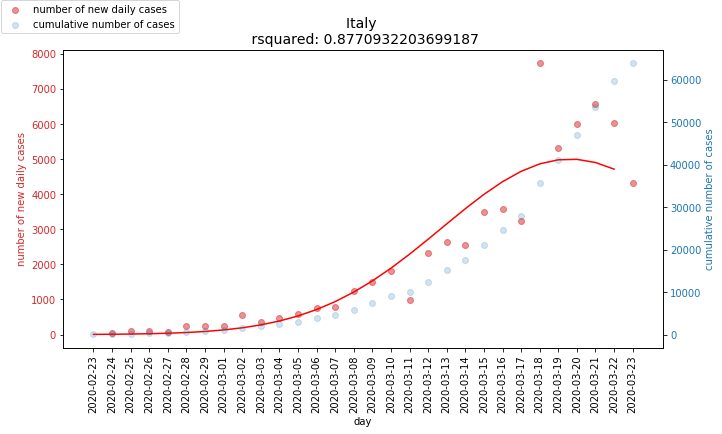

rsquare: 0.8687503089916488


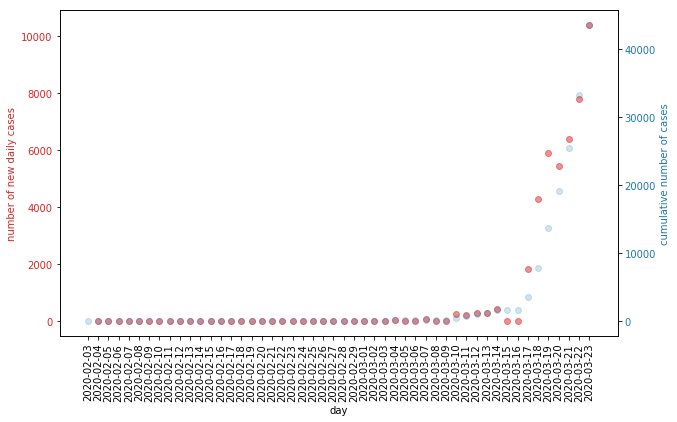

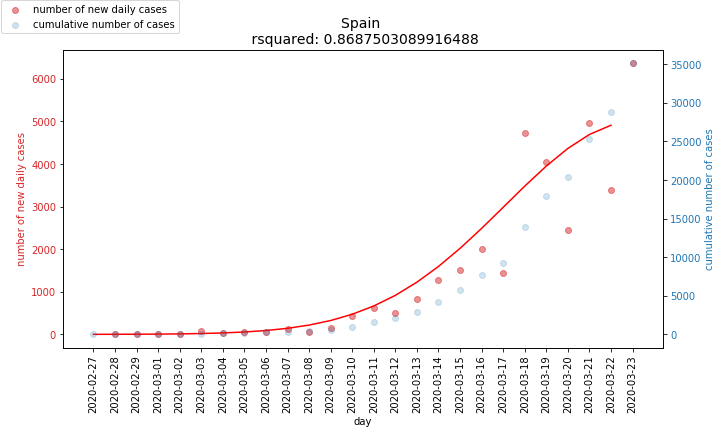

rsquare: 0.7883103471532177


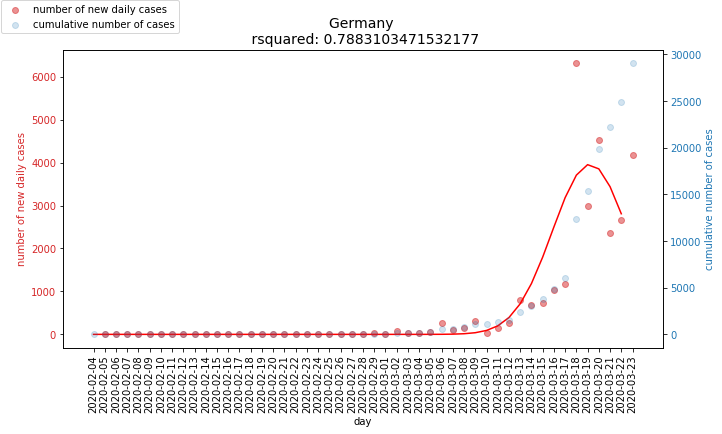

rsquare: 0.5842177342810086


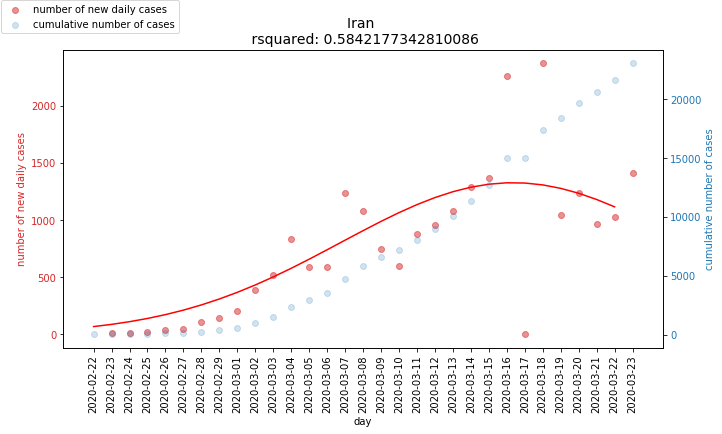

rsquare: 0.8801345870145801


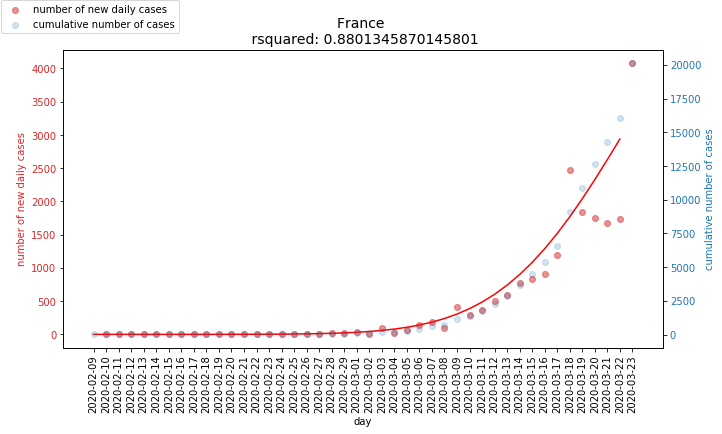

rsquare: 0.8932706169310249


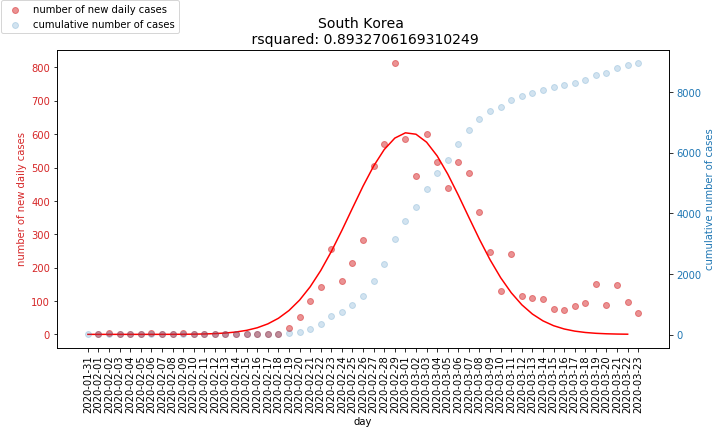

rsquare: 0.8051408344470113


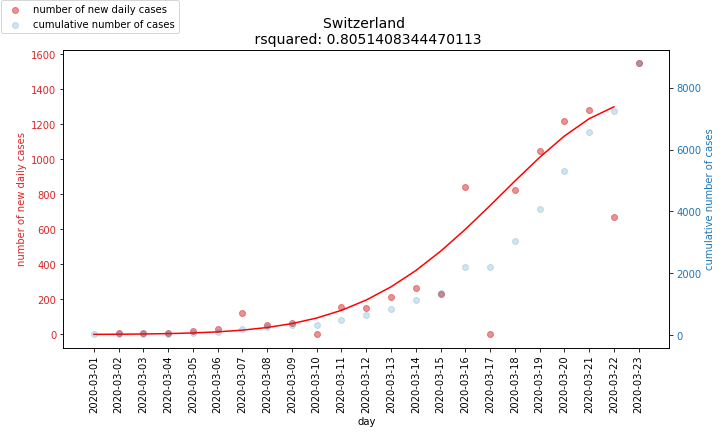

rsquare: 0.7197009360296028


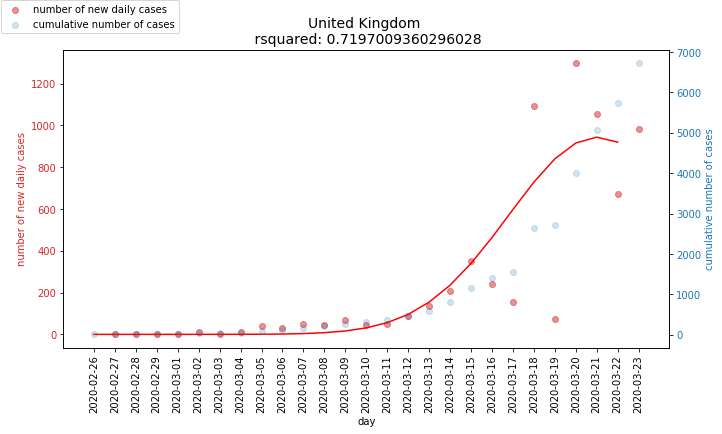

rsquare: 0.9148100317803365


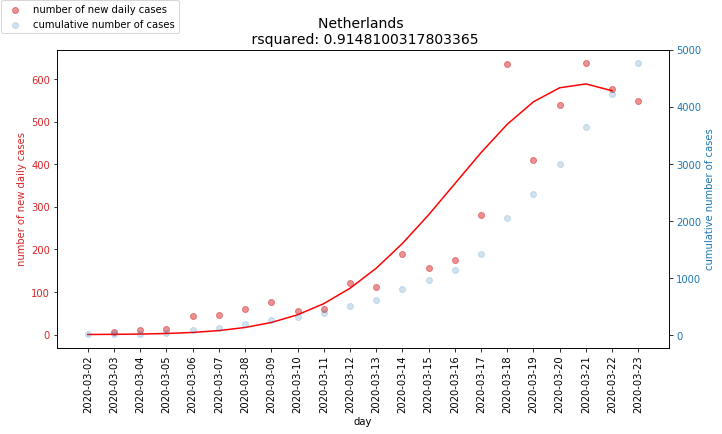

In [15]:
for country in top10:
    try:
        df_part = df[country]
        df_part = df_part.loc[df_part>10] #checks for at least 10 cases

        # taking derivative
        d1 = df_part.diff()

        if region == 'china':
            d1.drop(index='2020-02-17', inplace=True)


        data1 = [d1.index, d1]
        data2 = [df_part.index, df_part]

        fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

        color = 'tab:red'
        ax1.set_xlabel('day')
        ax1.set_ylabel('number of new daily cases', color=color)
        ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.tick_params(axis='x', rotation=90)


        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
        ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
        ax2.tick_params(axis='y', labelcolor=color)

        # SVR poly kernel on the second derivative
        dd1 = d1.reset_index(drop=True)
        dd1 = dd1.dropna()
        X = np.array(dd1.index)
        y = np.array(dd1)



        # regression
        bounds = ([50,15,0],[5000,90,20])
        params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
        # print(params)

        # residuals
        residuals = y - fx(X,*params)
        ssres = np.sum(residuals**2)
        sstot = np.sum((y-np.mean(y))**2)
        rsquared = 1-(ssres/sstot)
        print('rsquare: {}'.format(rsquared))

        ax1.plot(fx(X,*params), c='r')

        fig.legend(borderaxespad=0.1, loc='upper left')
        ax1.set_title('{0} \n rsquared: {1}'.format(country,rsquared), fontsize=14)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped

        plt.tight_layout()
        plt.savefig('./figures/figure9_{}.png'.format(country), dpi=300)


        plt.show()
    except:
        pass

rsquare: 0.8376293141257218


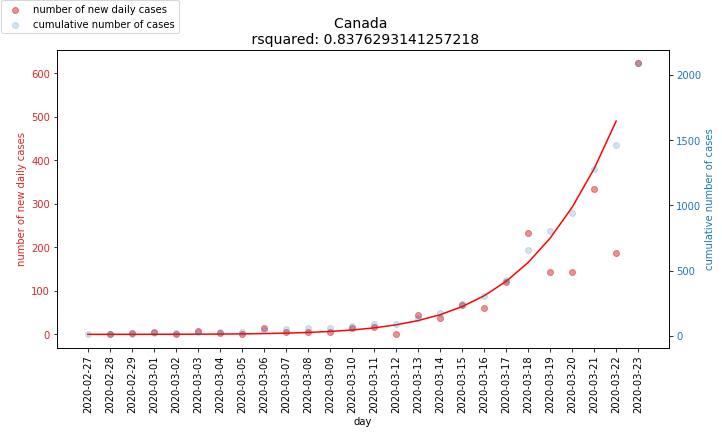

In [39]:
country = 'Canada'

df_part = df[country]
df_part = df_part.loc[df_part>10] #checks for at least 10 cases

# taking derivative
d1 = df_part.diff()

if region == 'china':
    d1.drop(index='2020-02-17', inplace=True)


data1 = [d1.index, d1]
data2 = [df_part.index, df_part]

fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('day')
ax1.set_ylabel('number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
ax2.tick_params(axis='y', labelcolor=color)

# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)



# regression
bounds = ([50,15,0],[5000,90,20])
# bounds = ([50,15,0],[np.inf,90,20])
params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
# print(params)

# residuals
residuals = y - fx(X,*params)
ssres = np.sum(residuals**2)
sstot = np.sum((y-np.mean(y))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))

ax1.plot(fx(X,*params), c='r')
ax1.set_title('{0} \n rsquared: {1}'.format(country,rsquared), fontsize=14)

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.tight_layout()
plt.savefig('./figures/figure8.png', dpi=300)


plt.show()

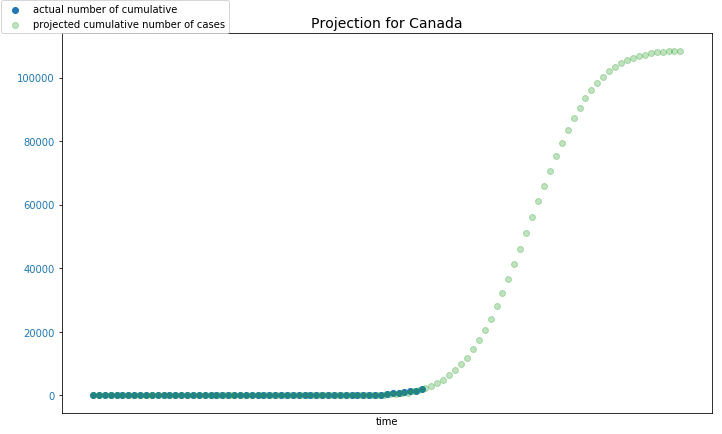

estimated total after 100 days: 108,527


In [40]:

# Projections
df_part = df[country]
df_part = df_part.loc[df_part>0] #checks for at least 10 cases

# taking derivative
d1 = df_part.diff()

# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)



# regression
bounds = ([50,15,0],[5000,90,20])
params, params_cov = optimize.curve_fit(fx,X,y, bounds=bounds)
# print(params)

days = 100
t = np.linspace(0,days,days)

y1 = fx(t,*params)
red = [df_part.index, df_part]
blue = [t, np.cumsum(y1)]



fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('Projection for {}'.format(country), fontsize=14)

color = 'tab:blue'
ax1.set_xlabel('time')
# ax1.set_ylabel('actual number of cumulative', color=color)
ax1.scatter(*red, color=color, alpha = 1, label='actual number of cumulative')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
# ax1.set_ylabel('projected cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax1.scatter(*blue, color=color, alpha=0.3, label = 'projected cumulative number of cases')
# ax2.tick_params(axis='y', labelcolor=color)

# SVR poly kernel on the second derivative
dd1 = d1.reset_index(drop=True)
dd1 = dd1.dropna()
X = np.array(dd1.index)
y = np.array(dd1)

# ax1.plot(fx(X,*params), c='r')

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.savefig('./figures/figure10.png', dpi=300)


plt.show()

print('estimated total after {0} days: {1:,}'.format(days,int(np.cumsum(y1)[-1])))